In [0]:
Τζόγκα Κώστας 1115201600171 - Βαγγέλης Τάτογλου 1115201500157

<h1>ΔΙΑΧΩΡΙΣΜΟΣ ΔΕΔΟΜΕΝΩΝ</h1>
Κατά τον διαχωρισμό των δεδομένων δημιουργούνται 3 tsv αρχεία. Το train_set, το test_set και ένα ακόμη που περιέχει όλα τα δεδόμενα. <br>

<h1>CLASSIFICATION - Beat the benchmark</h1>
Για το 3ο ερώτημα (beat the benchmark) επιλέχθηκε το classification με SVM. Για να επιτεχθεί αυτό, υπήρξε προεπεξεργασία των δεδομένων. Συγκεκριμένα, υπήρξε μετατροπή όλων χαρακτήρων απο απο upper σε lower case και lemmatization. Υπήρξε μεγαλύτερη μεγαλύτερη απόδοση σε όλες τις μετρικές. 

<h1>CLUSTERING</h1>
Για το data visualization επιλέχθηκαν οι μέθοδοι Principal Component Analysis (PCA), Singular Value Decomposition (SVD) και Independent Component Analysis (ICA). Κάθε cluster παρουσιάζεται με ένα διαφορετικό χρώμα, έτσι ώστε να είναι δυνατόν να διακριθούν οι διαφορετικές predicted ομάδες. Κάθε διάνυσμα παρουσιάζεται με ένα γράμμα ανάμεσα στα B (Business), E (entertainment), P (Politics, S (Sports), T (Tech). Με αυτόν τον τρόπο είναι δυνατόν να διακρίνουμε το ποσοστό επιτυχίας του clustering. <br>
Για την αναπαράσταση των document-embeddings χρησιμοποιήθηκε το pre-trained μοντέλο απο το αρχείο GoogleNews-vectors-negative300.bin.<br>
Η μετατροπή κάθε άρθρου σε διάνυσμα έγινε παίρνοντας τον μέσο όρο του κάθε συντεταγμένης όλων των λέξεων-διανύσματων (word-embeddings).<br>



CREATE FILES

In [0]:
import numpy as np
from sklearn.model_selection import train_test_split
import os
import pandas as pd
 
def read_title_from_file(file_name):
	with open(file_name, 'rb') as f:
		return f.readline()

def read_content_from_file(file_name):
	with open(file_name, 'rb') as f:
		next(f)
		return f.read()

def create_dataframe(rootDir):
	df = pd.DataFrame(columns=['id', 'title', 'content', 'category'])
	id = 1
	for dirName, subdirList, fileList in os.walk(rootDir):
		category = os.path.basename(dirName)
		for fname in fileList:
			file_name = dirName + "/" + fname
			title = read_title_from_file(file_name).decode('utf-8').rstrip('\n')
			content = read_content_from_file(file_name).decode('ISO-8859-1').replace('\n', ' ')
			df = df.append([{'id':id,  'title':title, 'content':content, 'category':category}],
				ignore_index=True)
			id += 1
	return df

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

data_path = '/content/drive/My Drive/fulltext/data/'
df = create_dataframe(data_path)

X_train, X_test, y_train, y_test = train_test_split(df, df['category'], test_size=0.2,
	random_state=42, stratify=df['category'])

with open("data.csv", 'w+') as file:
	file.write(df.to_csv(index=False, sep='\t'))

with open("train_set.csv", 'w+') as file:
	file.write(X_train.to_csv(index=False, sep='\t'))

with open("test_set.csv", 'w+') as file:
	file.write(X_test.to_csv(index=False, sep='\t'))

WORDCLOUDS

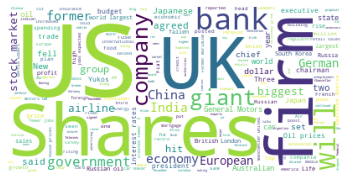

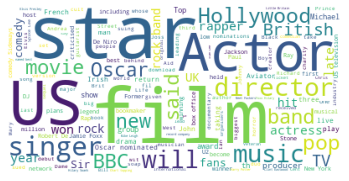

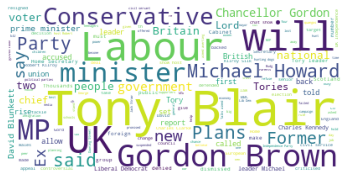

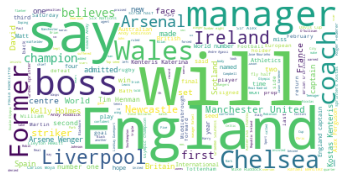

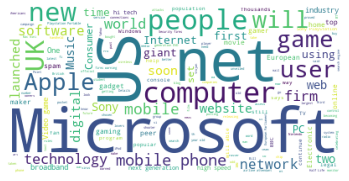

In [58]:
from sklearn.model_selection import train_test_split
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

def create_wordcloud(name, string):
	wordcloud = WordCloud(
		stopwords=STOPWORDS,
		background_color='white').generate(string)
	wordcloud.to_file(name)
	fig = plt.figure(1)
	plt.imshow(wordcloud)
	plt.axis('off')
	plt.show()
	fig.savefig(name, dpi=1200)

df_data = pd.read_csv("data.csv", sep='\t')
df_data['content'] = df_data['content'].str.replace('\.|\,', '', regex=True)

create_wordcloud("wordcloud_business.png",
    df_data[df_data['category'] == 'business']['content'].dropna().to_string())

create_wordcloud("wordcloud_entertain.png",
    df_data[df_data['category'] == 'entertainment']['content'].dropna().to_string())

create_wordcloud("wordcloud_politics.png",
    df_data[df_data['category'] == 'politics']['content'].dropna().to_string())

create_wordcloud("wordcloud_sport.png",
    df_data[df_data['category'] == 'sport']['content'].dropna().to_string())

create_wordcloud("wordcloud_tech.png",
    df_data[df_data['category'] == 'tech']['content'].dropna().to_string())

CLASSIFICATION

In [0]:
import pandas as pd
from sklearn import svm, preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, roc_curve, auc
from statistics import stdev
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics.pairwise import cosine_similarity
from itertools import groupby
from operator import itemgetter
from collections import Counter
from sklearn.model_selection import cross_val_predict
from itertools import cycle
from sklearn.preprocessing import label_binarize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize 
import nltk
from nltk import pos_tag
from nltk.corpus import wordnet as wn


class KNN_classifier(BaseEstimator, ClassifierMixin):
	def __init__(self, k=5):
		self.k = k
	
	def fit(self, X_train, y_train):
		self.X_train = X_train
		self.y_train = y_train
		return self

	def predict(self, X_test):
		predictions = []

		similarities = cosine_similarity(X_test, self.X_train)
		for (i, row) in enumerate(similarities):
			idx = np.argsort(-row)
			predictions.append(self.majority_voting(idx[:self.k]))

		return predictions
	
	def majority_voting(self, neighbors):
		counts = Counter(iter(y_train[neighbors])).most_common()
		maxcount, mode_items = next(groupby(counts, key=itemgetter(1)), (0, []))
		return list(map(itemgetter(0), mode_items))[0]


def evaluation(clf, X_train, y_train, y_test, predictions, figure_num, flag=True):
	# precision_micro recall_micro f1_micro evaluation
	precisions = cross_val_score(clf, X_train, y_train, cv=10, scoring='precision_weighted')
	print ('Precision (mean, stdev): ', np.mean(precisions), stdev(precisions), precisions)
	recalls = cross_val_score(clf, X_train, y_train, cv=10, scoring='recall_weighted')
	print ('Recalls (mean, stdev): ', np.mean(recalls), stdev(recalls), precisions)
	f1s = cross_val_score(clf, X_train, y_train, cv=10, scoring='f1_weighted')
	print ('F1 (mean, stdev): ', np.mean(f1s), stdev(f1s), precisions)

	# accuracy evaluation
	accuracies = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
	print ('Accuracy (mean, stdev): ', np.mean(accuracies), stdev(accuracies), accuracies)

	print ('Accuracy on test data: ', accuracy_score(y_test, predictions))

	# ROC evaluation
	if flag == True:
		roc_evaluation(clf, X_train, y_train, [0, 1, 2, 3, 4], figure_num)

def roc_evaluation(clf, X_train, y_train, labels, figure_num):
	# Binarize the output
	y_bin = label_binarize(y_train, classes=labels)
	n_classes = y_bin.shape[1]

	y_score = cross_val_predict(clf, X_train, y_train, cv=10 ,method='predict_proba')

	fpr = dict()
	tpr = dict()
	roc_auc = dict()
	for i in range(n_classes):
		fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
		roc_auc[i] = auc(fpr[i], tpr[i])
	colors = cycle(['blue', 'red', 'green'])
	plt.figure(num=figure_num, figsize=(10, 10))
	for i, color in zip(range(n_classes), colors):
		plt.plot(fpr[i], tpr[i], color=color,
				label='ROC curve of class {0} (area = {1:0.2f})'
				''.format(i, roc_auc[i]))

	plt.plot([0, 1], [0, 1], 'k--')
	plt.xlim([-0.05, 1.0])
	plt.ylim([0.0, 1.05])
	plt.xlabel('False Positive Rate')
	plt.ylabel('True Positive Rate')
	plt.title('Receiver operating characteristic for multi-class data')
	plt.legend(loc="lower right")
	plt.show()
	plt.savefig('roc_plot.png')

def wordnet_pos_code(tag):
	if tag in ['JJ', 'JJR', 'JJS']:
		return wn.ADJ
	elif tag in ['RB', 'RBR', 'RBS']:
		return wn.ADV
	elif tag in ['NN', 'NNS', 'NNP', 'NNPS']:
		return wn.NOUN
	elif tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']:
		return wn.VERB
	return wn.NOUN 

def lemmas(data):
	lemmatizer = WordNetLemmatizer() 
	return [lemmatizer.lemmatize(token, pos=wordnet_pos_code(tag)) for token, tag in data]

def lemmatization(data):
	try:
		data = lemmas(data)
	except LookupError:
		nltk.download('punkt')
		nltk.download('wordnet')
		nltk.download('averaged_perceptron_tagger')
		data = lemmas(data)
	return ' '.join(data)

def data_preprocessing(docs):
	new_docs = []
	for doc in docs:
		doc = pos_tag(word_tokenize(doc))
		new_docs.append(lemmatization(doc))

	return new_docs

if __name__ == "__main__":
	# read data
	df_train = pd.read_csv("train_set.csv", sep='\t')
	df_train['content'] = df_train['content'].str.replace('\.|\,', '', regex=True)
	df_test = pd.read_csv("test_set.csv", sep='\t')
	df_test['content'] = df_test['content'].str.replace('\.|\,', '', regex=True)

	# vectorization by CountVectorizer
	count_vectorizer = CountVectorizer(stop_words='english')
	X_train_count = count_vectorizer.fit_transform(df_train['content'])
	X_test_count = count_vectorizer.transform(df_test['content'])

	# vectorization by TfidfVectorizer
	tfidf_vectorizer = TfidfVectorizer(stop_words='english')
	X_train_tfidf = tfidf_vectorizer.fit_transform(df_train['content'])
	X_test_tfidf = tfidf_vectorizer.transform(df_test['content'])

	# labels
	le = preprocessing.LabelEncoder()
	le.fit(df_train['category'])
	y_train = le.transform(df_train['category'])
	y_test = le.transform(df_test['category'])

SVM - CountVectorizer 

SUPPORT VECTOR MACHINES (Bow):
Precision (mean, stdev):  0.9514566999654482 0.011251345325910494 [0.94539731 0.94639971 0.93998936 0.96286784 0.9579053  0.9579004
 0.93503081 0.94696003 0.972412   0.94970424]
Recalls (mean, stdev):  0.9488764044943819 0.011679749909747352 [0.94539731 0.94639971 0.93998936 0.96286784 0.9579053  0.9579004
 0.93503081 0.94696003 0.972412   0.94970424]
F1 (mean, stdev):  0.9490638901979072 0.01162161369436241 [0.94539731 0.94639971 0.93998936 0.96286784 0.9579053  0.9579004
 0.93503081 0.94696003 0.972412   0.94970424]
Accuracy (mean, stdev):  0.9488764044943819 0.011679749909747352 [0.94382022 0.94382022 0.93820225 0.96067416 0.95505618 0.95505618
 0.93258427 0.94382022 0.97191011 0.94382022]
Accuracy on test data:  0.9662921348314607


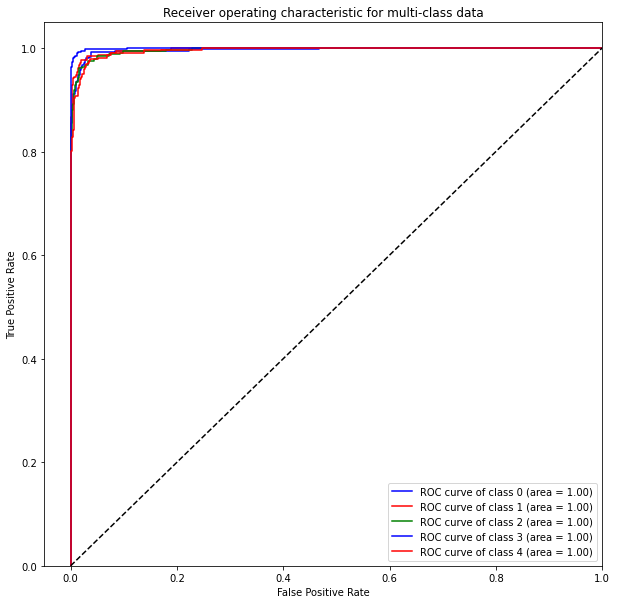

<Figure size 432x288 with 0 Axes>

In [29]:
# fit
clf = svm.SVC(probability=True)
# clf = GridSearchCV(clf, {'kernel':('linear', 'rbf'), 'C':[1, 10]})

clf.fit(X_train_count, y_train)

# predict
predictions_count = clf.predict(X_test_count)

# print evaluations scores
print("SUPPORT VECTOR MACHINES (Bow):")
evaluation(clf, X_train_count, y_train, y_test, predictions_count, 1)

SVM - TfIdfVectorizer

SUPPORT VECTOR MACHINES (TfIdf):
Precision (mean, stdev):  0.9725879160474937 0.0076476059101941475 [0.97234289 0.96702389 0.96024674 0.978496   0.96766781 0.96666623
 0.9842952  0.9729802  0.98314607 0.97301414]
Recalls (mean, stdev):  0.9713483146067414 0.008561145655926914 [0.97234289 0.96702389 0.96024674 0.978496   0.96766781 0.96666623
 0.9842952  0.9729802  0.98314607 0.97301414]
F1 (mean, stdev):  0.971315216412407 0.008618158567965772 [0.97234289 0.96702389 0.96024674 0.978496   0.96766781 0.96666623
 0.9842952  0.9729802  0.98314607 0.97301414]
Accuracy (mean, stdev):  0.9713483146067414 0.008561145655926914 [0.97191011 0.96629213 0.95505618 0.97752809 0.96629213 0.96629213
 0.98314607 0.97191011 0.98314607 0.97191011]
Accuracy on test data:  0.9820224719101124


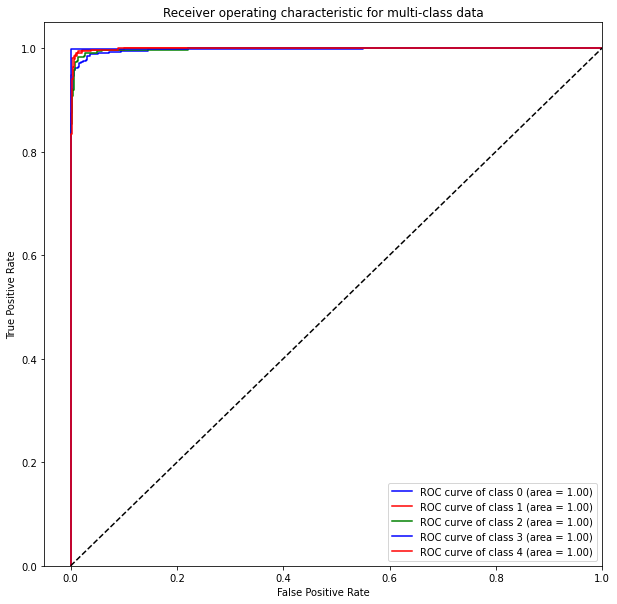

<Figure size 432x288 with 0 Axes>

In [28]:
# fit
clf = svm.SVC(probability=True)
# clf = GridSearchCV(clf, {'kernel':('linear', 'rbf'), 'C':[1, 10]})

clf.fit(X_train_tfidf, y_train)

# predict
predictions_count = clf.predict(X_test_tfidf)

# print evaluations scores
print("SUPPORT VECTOR MACHINES (TfIdf):")
evaluation(clf, X_train_tfidf, y_train, y_test, predictions_count, 2)

Random Forests - CountVectorizer

RANDOM FORESTS (Counts):
Precision (mean, stdev):  0.8819948562306619 0.011529995017952344 [0.87805887 0.8720482  0.87992472 0.87476776 0.89568906 0.88442748
 0.86653108 0.87681575 0.90539766 0.88628797]
Recalls (mean, stdev):  0.8466292134831461 0.022789577418091844 [0.87805887 0.8720482  0.87992472 0.87476776 0.89568906 0.88442748
 0.86653108 0.87681575 0.90539766 0.88628797]
F1 (mean, stdev):  0.8395861148306798 0.024639755461194478 [0.87805887 0.8720482  0.87992472 0.87476776 0.89568906 0.88442748
 0.86653108 0.87681575 0.90539766 0.88628797]
Accuracy (mean, stdev):  0.8466292134831461 0.022789577418091844 [0.84831461 0.83146067 0.84269663 0.8258427  0.87640449 0.86516854
 0.80898876 0.83707865 0.88202247 0.84831461]
Accuracy on test data:  0.8561797752808988


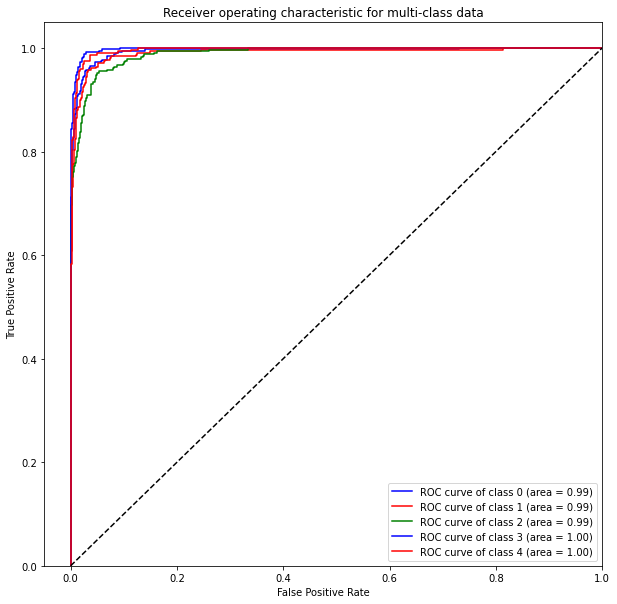

<Figure size 432x288 with 0 Axes>

In [0]:
# fit
clf = RandomForestClassifier(max_depth=4, random_state=0)

clf.fit(X_train_count, y_train)

# predict
predictions_count = clf.predict(X_test_count)

# print evaluations scores
print("RANDOM FORESTS (Counts):")
evaluation(clf, X_train_count, y_train, y_test, predictions_count, 3)

Random Forests - TfIdfVectorizer

RANDOM FORESTS (TfIdf):
Precision (mean, stdev):  0.885473132623984 0.01648703230772991 [0.8975278  0.88446828 0.89675049 0.87624356 0.90898494 0.89291915
 0.8567876  0.87788632 0.89844509 0.8647181 ]
Recalls (mean, stdev):  0.8544943820224719 0.0321585256142747 [0.8975278  0.88446828 0.89675049 0.87624356 0.90898494 0.89291915
 0.8567876  0.87788632 0.89844509 0.8647181 ]
F1 (mean, stdev):  0.8487660072578393 0.03487082574617342 [0.8975278  0.88446828 0.89675049 0.87624356 0.90898494 0.89291915
 0.8567876  0.87788632 0.89844509 0.8647181 ]
Accuracy (mean, stdev):  0.8466292134831461 0.022789577418091844 [0.84831461 0.83146067 0.84269663 0.8258427  0.87640449 0.86516854
 0.80898876 0.83707865 0.88202247 0.84831461]
Accuracy on test data:  0.8359550561797753


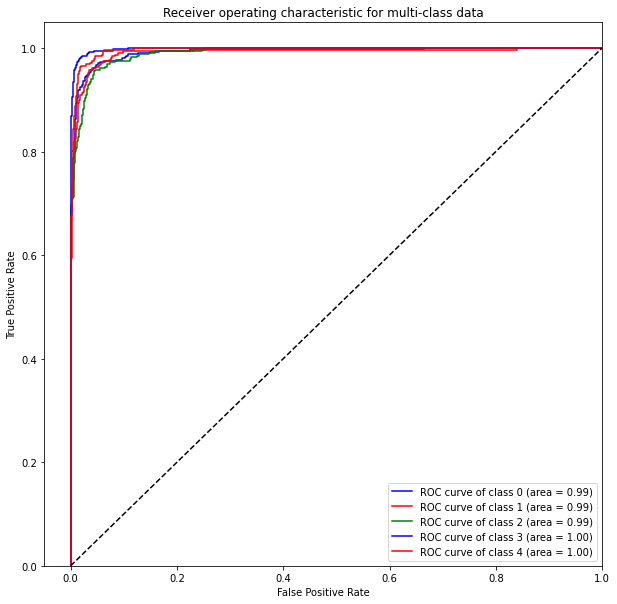

<Figure size 432x288 with 0 Axes>

In [0]:
# fit
clf = RandomForestClassifier(max_depth=4, random_state=0)

clf.fit(X_train_tfidf, y_train)

# predict
predictions_count = clf.predict(X_test_tfidf)

# print evaluations scores
print("RANDOM FORESTS (TfIdf):")
evaluation(clf, X_train_tfidf, y_train, y_test, predictions_count, 4)

Naive Bayes - CountVectorizer

Naive Bayes (Counts):
Precision (mean, stdev):  0.9309672594713317 0.019614743585572622 [0.93371767 0.94494146 0.93317076 0.91881245 0.94578226 0.91013905
 0.89577373 0.95189256 0.95624455 0.9191981 ]
Recalls (mean, stdev):  0.9286516853932584 0.020522499165239672 [0.93371767 0.94494146 0.93317076 0.91881245 0.94578226 0.91013905
 0.89577373 0.95189256 0.95624455 0.9191981 ]
F1 (mean, stdev):  0.9287515839830294 0.02051690208327608 [0.93371767 0.94494146 0.93317076 0.91881245 0.94578226 0.91013905
 0.89577373 0.95189256 0.95624455 0.9191981 ]
Accuracy (mean, stdev):  0.9286516853932584 0.020522499165239672 [0.93258427 0.94382022 0.93258427 0.91573034 0.94382022 0.90449438
 0.89325843 0.9494382  0.95505618 0.91573034]
Accuracy on test data:  0.9348314606741573


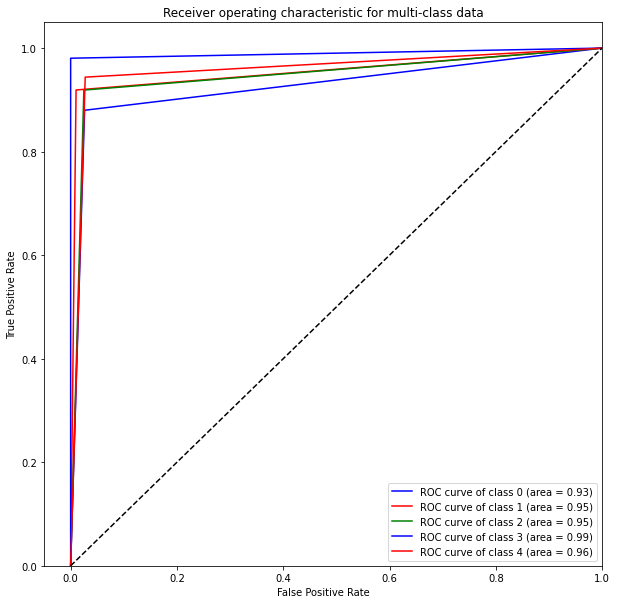

<Figure size 432x288 with 0 Axes>

In [0]:
# fit
clf = GaussianNB()

clf.fit(X_train_count.toarray(), y_train)

# predict
predictions_count = clf.predict(X_test_count.toarray())

# print evaluations scores
print("Naive Bayes (Counts):")
evaluation(clf, X_train_count.toarray(), y_train, y_test, predictions_count, 5)

Naive Bayes - TfidfVectorizer

Naive Bayes (TfIdf):
Precision (mean, stdev):  0.9215586873938942 0.024112966204706123 [0.9225026  0.93487159 0.92250805 0.9224291  0.94097544 0.8971967
 0.87230387 0.94560822 0.95072212 0.90646919]
Recalls (mean, stdev):  0.9196629213483145 0.024279659937622378 [0.9225026  0.93487159 0.92250805 0.9224291  0.94097544 0.8971967
 0.87230387 0.94560822 0.95072212 0.90646919]
F1 (mean, stdev):  0.9196789406650113 0.02445437289016222 [0.9225026  0.93487159 0.92250805 0.9224291  0.94097544 0.8971967
 0.87230387 0.94560822 0.95072212 0.90646919]
Accuracy (mean, stdev):  0.9196629213483145 0.024279659937622378 [0.92134831 0.93258427 0.92134831 0.92134831 0.93820225 0.89325843
 0.87078652 0.94382022 0.9494382  0.90449438]
Accuracy on test data:  0.9235955056179775


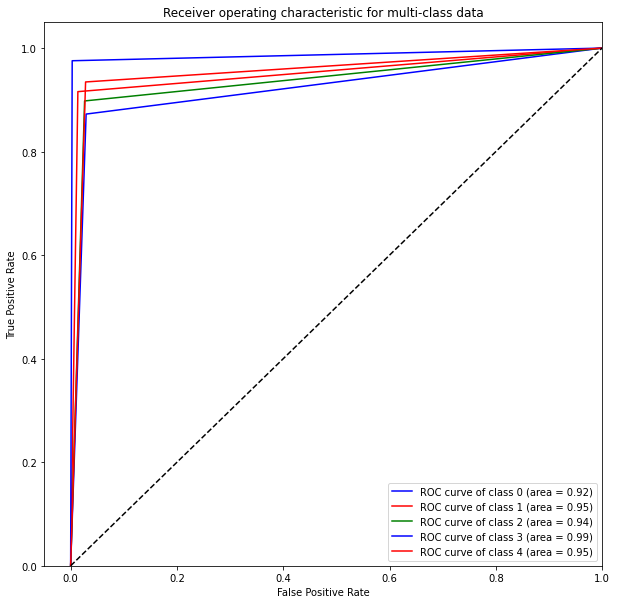

<Figure size 432x288 with 0 Axes>

In [0]:
# fit
clf = GaussianNB()

clf.fit(X_train_tfidf.toarray(), y_train)

# predict
predictions_count = clf.predict(X_test_tfidf.toarray())

# print evaluations scores
print("Naive Bayes (TfIdf):")
evaluation(clf, X_train_tfidf.toarray(), y_train, y_test, predictions_count, 6)

KNN - CountVectorizer

In [0]:
# fit
clf = KNN_classifier(5)

clf.fit(X_train_count, y_train)

# predict
predictions_count = clf.predict(X_test_count)

# print evaluations scores
print("k-nearest neighbors (Bow):")
evaluation(clf, X_train_count, y_train, y_test, predictions_count, 7, False)

k-nearest neighbors (Bow):
Precision (mean, stdev):  0.6516840351560182 0.27403770319662285 [0.2194028  0.3403023  0.36492952 0.50037813 0.67506327 0.80348196
 0.81952033 0.9110911  0.94752121 0.93514974]
Recalls (mean, stdev):  0.65 0.2712713424377139 [0.2194028  0.3403023  0.36492952 0.50037813 0.67506327 0.80348196
 0.81952033 0.9110911  0.94752121 0.93514974]
F1 (mean, stdev):  0.6482264149622696 0.2724424366363446 [0.2194028  0.3403023  0.36492952 0.50037813 0.67506327 0.80348196
 0.81952033 0.9110911  0.94752121 0.93514974]
Accuracy (mean, stdev):  0.65 0.2712713424377139 [0.21910112 0.34269663 0.37078652 0.5        0.6741573  0.79213483
 0.81460674 0.91011236 0.94382022 0.93258427]
Accuracy on test data:  0.9325842696629213


KNN - TfidfVectorizer

In [0]:
# fit
clf = KNN_classifier(5)

clf.fit(X_train_tfidf, y_train)

# predict
predictions_count = clf.predict(X_test_tfidf)

# print evaluations scores
print("k-nearest neighbors (TfIdf):")
evaluation(clf, X_train_tfidf, y_train, y_test, predictions_count, 8, False)

k-nearest neighbors (TfIdf):
Precision (mean, stdev):  0.6524710448079968 0.2754040517887797 [0.18508651 0.31822628 0.43124627 0.53596128 0.62961215 0.78707021
 0.83881339 0.91388497 0.9501673  0.93464208]
Recalls (mean, stdev):  0.6488764044943821 0.2757105109031884 [0.18508651 0.31822628 0.43124627 0.53596128 0.62961215 0.78707021
 0.83881339 0.91388497 0.9501673  0.93464208]
F1 (mean, stdev):  0.6483888412283736 0.2754971110361766 [0.18508651 0.31822628 0.43124627 0.53596128 0.62961215 0.78707021
 0.83881339 0.91388497 0.9501673  0.93464208]
Accuracy (mean, stdev):  0.6488764044943821 0.2757105109031884 [0.18539326 0.31460674 0.42134831 0.53370787 0.62359551 0.78089888
 0.83707865 0.91011236 0.9494382  0.93258427]
Accuracy on test data:  0.9438202247191011


In [0]:
BEAT THE BENCHMARK

In [0]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

In [0]:
# vectorization by CountVectorizer
count_vectorizer = CountVectorizer(stop_words='english')
preprocessed_train_data = data_preprocessing(df_train['content'].tolist())
preprocessed_test_data = data_preprocessing(df_test['content'].tolist())
X_train_count = count_vectorizer.fit_transform(preprocessed_train_data)
X_test_count = count_vectorizer.transform(preprocessed_test_data)

# fit
clf = KNN_classifier(5)

clf.fit(X_train_count, y_train)

# predict
predictions_count = clf.predict(X_test_count)

# print evaluations scores
print("SUPPORT VECTOR MACHINES (beat the benchmark):")
evaluation(clf, X_train_count, y_train, y_test, predictions_count, 9, False)

SUPPORT VECTOR MACHINES (beat the benchmark):
Precision (mean, stdev):  0.6626182557923245 0.27666425811749545 [0.18596407 0.35663456 0.37478726 0.58676503 0.67340715 0.795677
 0.82609457 0.95083912 0.92884817 0.94716562]
Recalls (mean, stdev):  0.6612359550561797 0.27389585064930005 [0.18596407 0.35663456 0.37478726 0.58676503 0.67340715 0.795677
 0.82609457 0.95083912 0.92884817 0.94716562]
F1 (mean, stdev):  0.6596568487559772 0.2752293474141446 [0.18596407 0.35663456 0.37478726 0.58676503 0.67340715 0.795677
 0.82609457 0.95083912 0.92884817 0.94716562]
Accuracy (mean, stdev):  0.6612359550561797 0.27389585064930005 [0.19101124 0.35955056 0.37640449 0.58426966 0.66853933 0.79213483
 0.82022472 0.9494382  0.92696629 0.94382022]
Accuracy on test data:  0.9393258426966292


CLUSTERING

In [0]:
import pandas as pd
from sklearn import preprocessing, metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, roc_curve, auc
from statistics import stdev
import matplotlib.pyplot as plt
from nltk.cluster import KMeansClusterer, cosine_distance
from sklearn.decomposition import PCA, TruncatedSVD, FastICA
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import gensim.downloader as api


def multi_classify(clusterer, X_test):
	clusters = []
	for query in X_test.toarray():
		cluster = clusterer.classify(query)
		clusters.append(cluster)

	return clusters

def get_indices(array, value):
	return [i for i, x in enumerate(array) if x == value]

def plot_data(clusters, k, points, categories, method_name):
	colours = ['red', 'blue', 'green', 'black', 'pink']
	markers = ['$B$', '$E$', '$P$', '$S$', '$T$']
	for i in range(k):
		indices = get_indices(clusters, i)
		cluster_i = points[get_indices(clusters, i)]
		for row, point in enumerate(cluster_i):
			plt.scatter(point[0], point[1], c=colours[i],
				marker=markers[categories[indices[row]]])

	plt.xlabel('X')
	plt.ylabel('Y')
	plt.title(method_name)

	red_patch = mpatches.Patch(color='red', label='cluster 0')
	blue_patch = mpatches.Patch(color='blue', label='cluster 1')
	green_patch = mpatches.Patch(color='green', label='cluster 2')
	black_patch = mpatches.Patch(color='black', label='cluster 3')
	pink_patch = mpatches.Patch(color='pink', label='cluster 4')

	b_mark = mlines.Line2D([], [], color='gray', marker='$B$',
		markersize=8, label='Business', linestyle='None')
	e_mark = mlines.Line2D([], [], color='gray', marker='$E$',
		markersize=8, label='Entertainment', linestyle='None')
	p_mark = mlines.Line2D([], [], color='gray', marker='$P$',
		markersize=8, label='politics', linestyle='None')
	s_mark = mlines.Line2D([], [], color='gray', marker='$S$',
		markersize=8, label='Sport', linestyle='None')
	t_mark = mlines.Line2D([], [], color='gray', marker='$T$',
		markersize=8, label='Tech', linestyle='None')
	
	plt.legend(handles=[red_patch, blue_patch, green_patch, black_patch,
			pink_patch, b_mark, e_mark, p_mark, s_mark, t_mark])
	plt.show()
	plt.savefig(method_name + '.png')

def get_embeddings(model, words, dimension):
	embeddings = []
	for word in words:
		try:
			embeddings.append(model[word])
		except:
			embeddings.append(np.zeros(dimension))

	return embeddings

def get_vectors_from_w2v(model, docs, dimension):
	vectors = []
	for doc in docs:
		embeddings = np.array(get_embeddings(model, doc, dimension))
		doc_vector = np.empty([0])
		for i in range(dimension):
			doc_vector = np.append(doc_vector, np.mean(embeddings[:, i]))

		vectors.append(doc_vector)
	return vectors

def plot_PCA_data(X_train, clusters, y_train, method_name):
	# PCA dimension reductionality 
	transformer = PCA(n_components=2, random_state=2020)
	pca_data = transformer.fit_transform(X_train)

	plot_data(clusters, 5, pca_data, y_train, method_name)	

def plot_SVD_data(X_train, clusters, y_train, method_name):
	# SVD dimension reductionality 
	svd = TruncatedSVD(random_state=42)
	svd_data = svd.fit_transform(X_train)

	plot_data(clusters, 5, svd_data, y_train, method_name)

def plot_ICA_data(X_train, clusters, y_train, method_name):
	# SVD dimension reductionality 
	ica = FastICA(n_components=2, random_state=42)
	ica_data = ica.fit_transform(X_train)

	plot_data(clusters, 5, ica_data, y_train, method_name)

if __name__ == "__main__":
	# read data
	df_train = pd.read_csv("train_set.csv", sep='\t')
	df_train['content'] = df_train['content'].str.replace('\.|\,', '', regex=True)

	# labels
	le = preprocessing.LabelEncoder()
	le.fit(df_train['category'])
	y_train = le.transform(df_train['category'])

CountVectorizer

In [0]:
count_vectorizer = CountVectorizer(stop_words='english')
X_train_count = count_vectorizer.fit_transform(df_train['content'])

# clustering
clusterer = KMeansClusterer(5, distance=cosine_distance)
clusters = clusterer.cluster(X_train_count.toarray(), True)

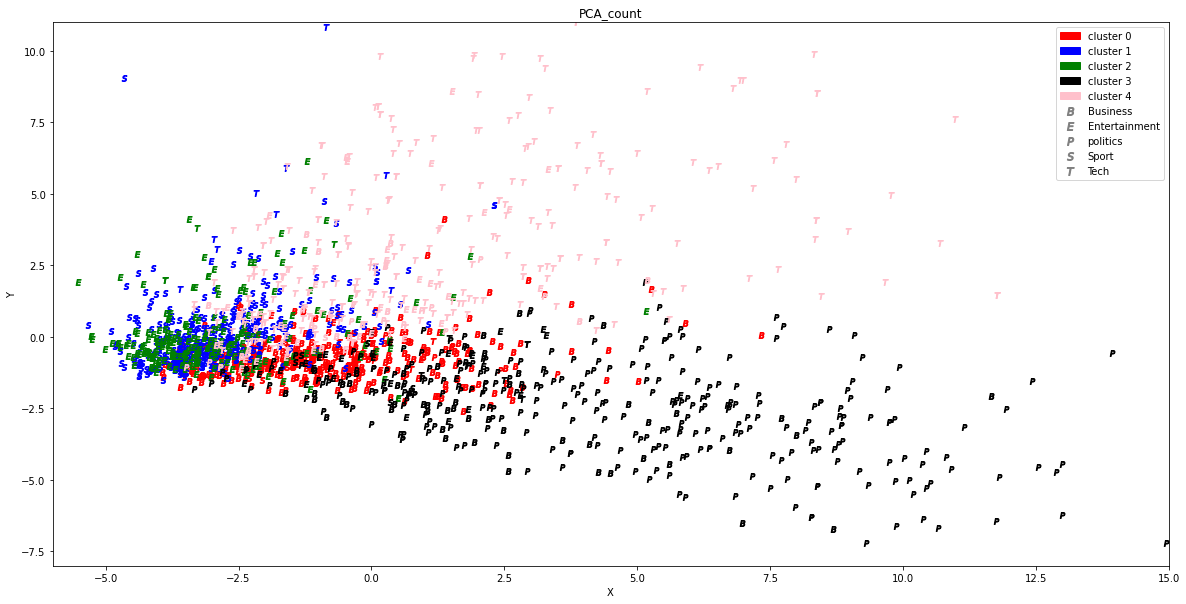

<Figure size 432x288 with 0 Axes>

In [56]:
plt.figure(1111, figsize=(20, 10))
plt.xlim([-6, 15])
plt.ylim([-8, 11])
plot_PCA_data(X_train_count.toarray(), clusters, y_train, 'PCA_count')

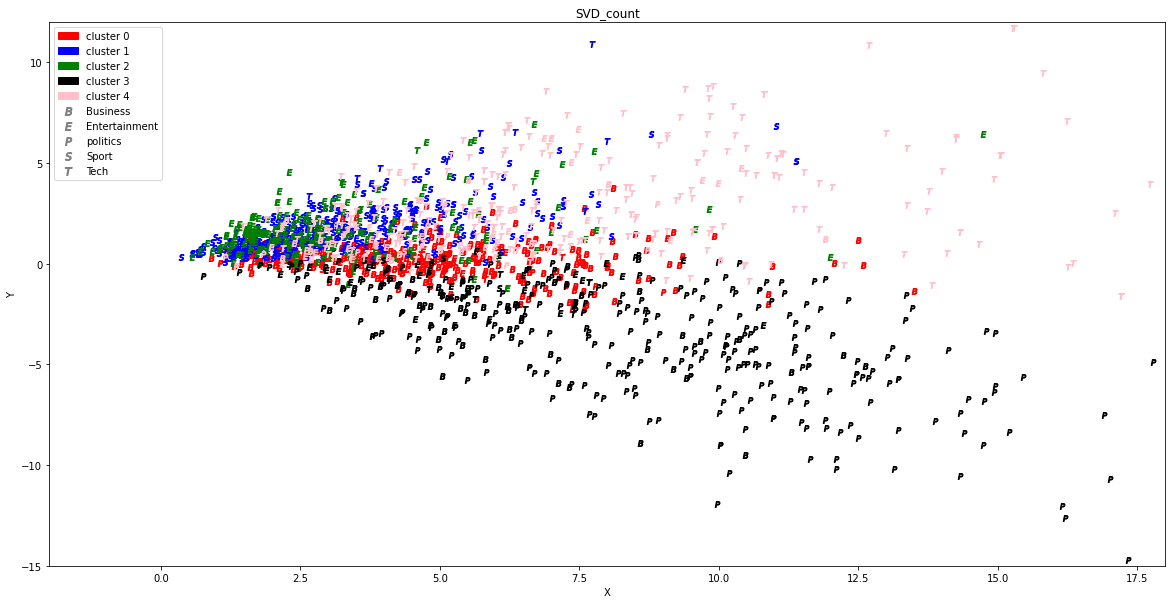

<Figure size 432x288 with 0 Axes>

In [57]:
plt.figure(num=2, figsize=(20, 10))
plt.xlim([-2, 18])
plt.ylim([-15, 12])
plot_SVD_data(X_train_count, clusters, y_train, 'SVD_count')

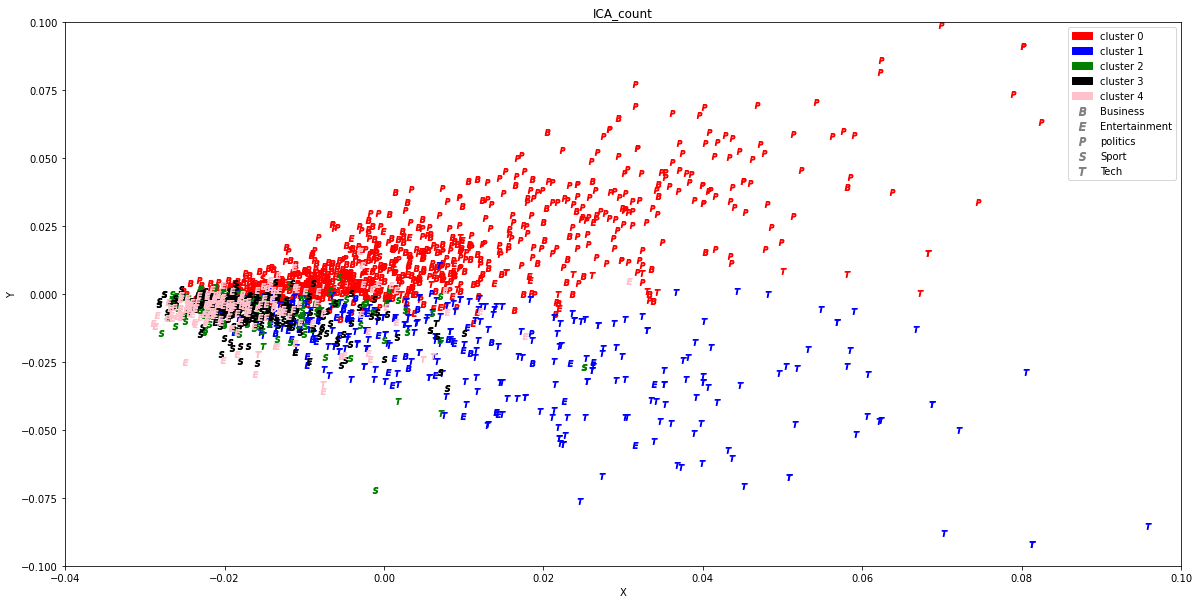

<Figure size 432x288 with 0 Axes>

In [40]:
plt.figure(num=333, figsize=(20, 10))
plt.xlim([-0.04, 0.1])
plt.ylim([-0.1, 0.1])
plot_ICA_data(X_train_count.toarray(), clusters, y_train, 'ICA_count')

TfidfVectorizer

In [0]:
# vectorization by TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(df_train['content'])

# clustering
clusterer = KMeansClusterer(5, distance=cosine_distance)
clusters = clusterer.cluster(X_train_tfidf.toarray(), True)

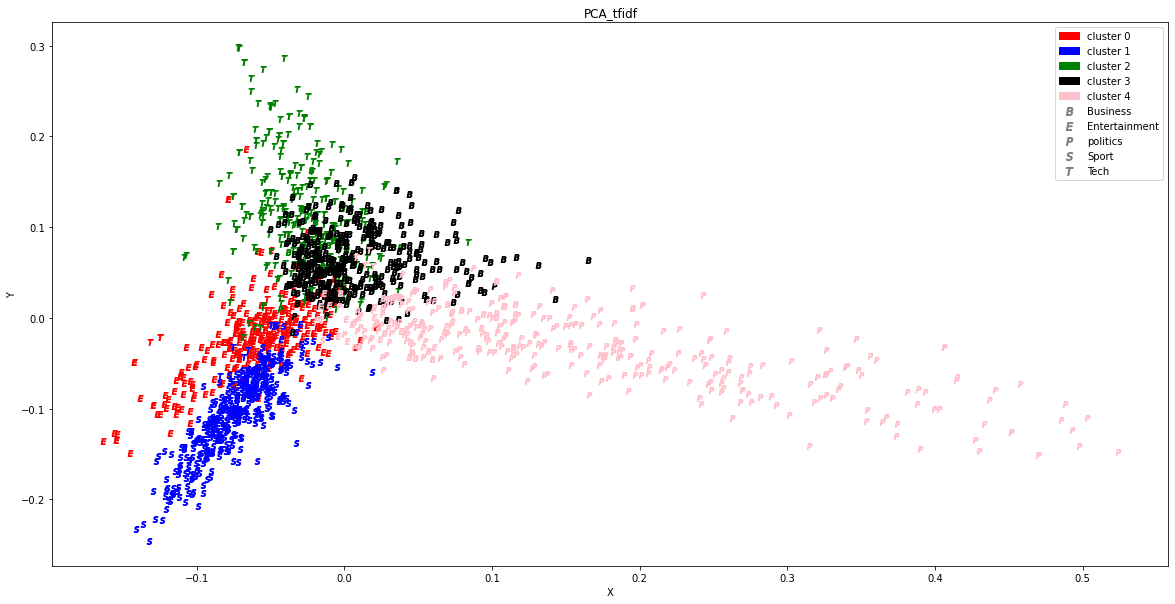

<Figure size 432x288 with 0 Axes>

In [0]:
plt.figure(num=4, figsize=(20, 10))
plot_PCA_data(X_train_tfidf.toarray(), clusters, y_train, 'PCA_tfidf')

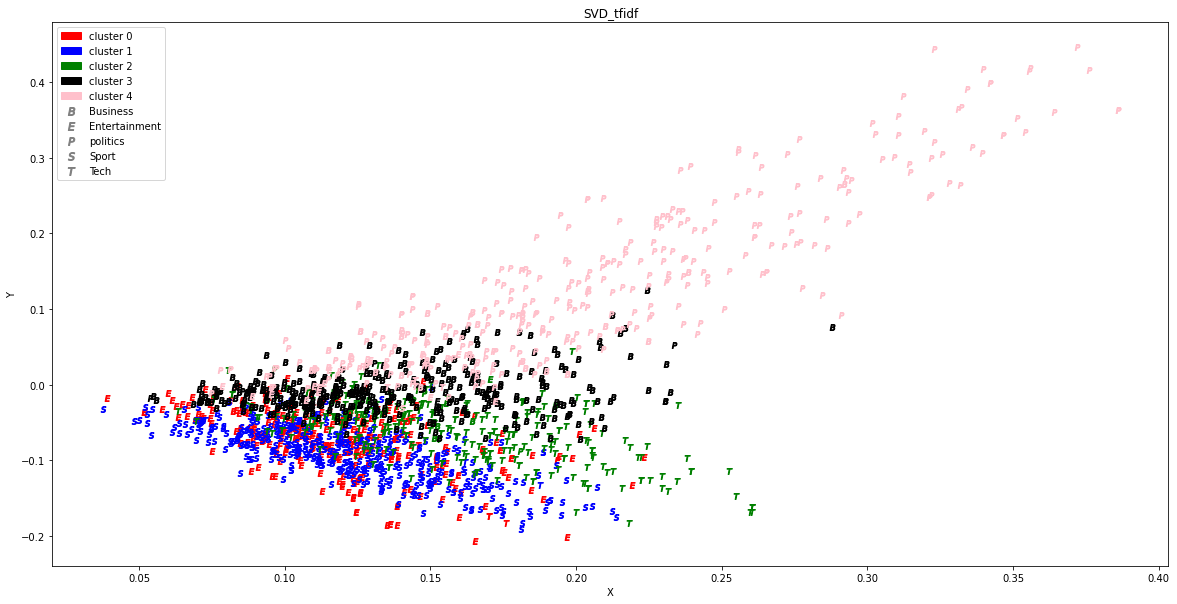

<Figure size 432x288 with 0 Axes>

In [0]:
plt.figure(num=5, figsize=(20, 10))
plot_SVD_data(X_train_tfidf, clusters, y_train, 'SVD_tfidf')

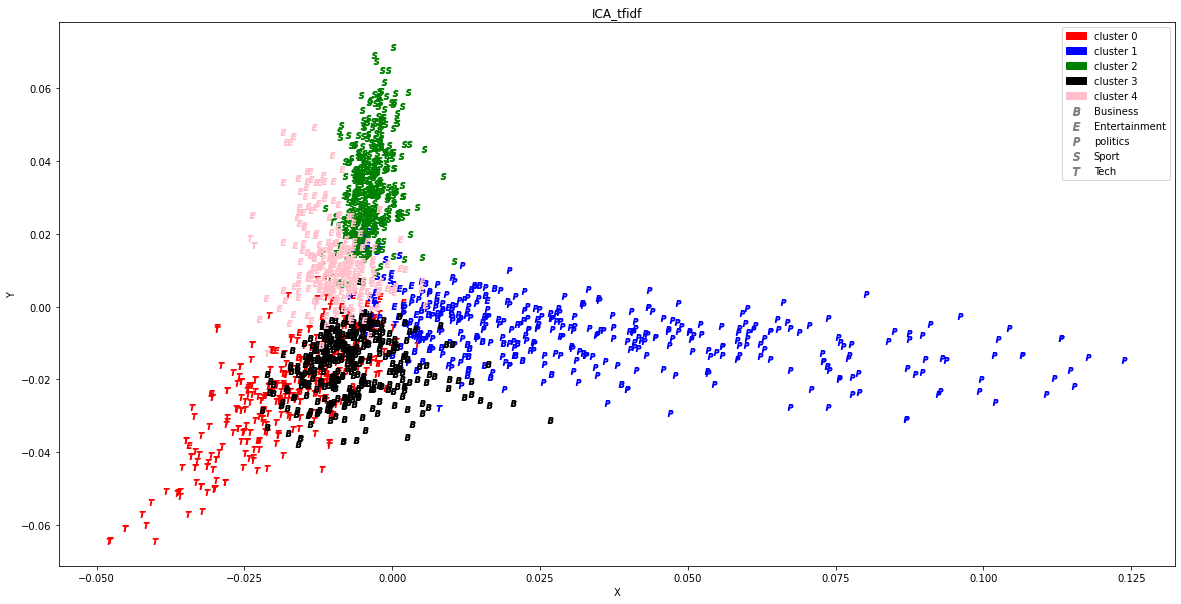

<Figure size 432x288 with 0 Axes>

In [42]:
plt.figure(num=6, figsize=(20, 10))
plot_ICA_data(X_train_tfidf.toarray(), clusters, y_train, 'ICA_tfidf')

document-embeddings 

In [14]:
pretrained_file_path = api.load("word2vec-google-news-300", return_path=True)

[================================================--] 96.4% 1602.4/1662.8MB downloaded


In [0]:
model = KeyedVectors.load_word2vec_format(pretrained_file_path, binary=True)  

# vectorization 
w2v_vectors = get_vectors_from_w2v(model, df_train['content'], model.vector_size)

# clustering
clusterer = KMeansClusterer(5, distance=cosine_distance)
clusters = clusterer.cluster(w2v_vectors, True)

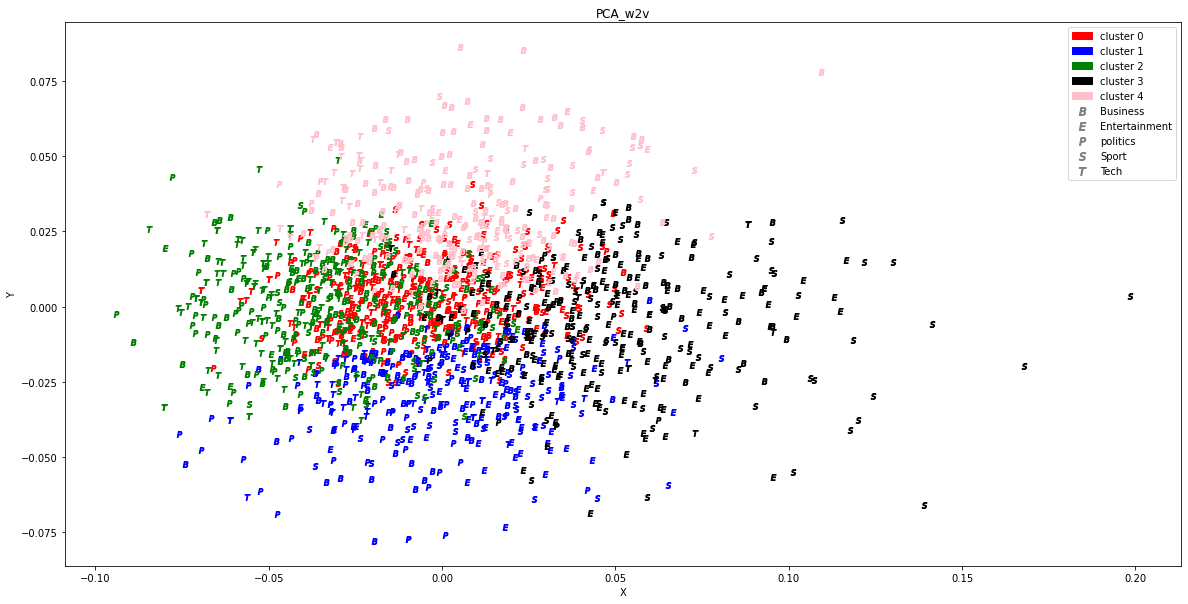

<Figure size 432x288 with 0 Axes>

In [17]:
plt.figure(num=7, figsize=(20, 10))
plot_PCA_data(w2v_vectors, clusters, y_train, 'PCA_w2v')

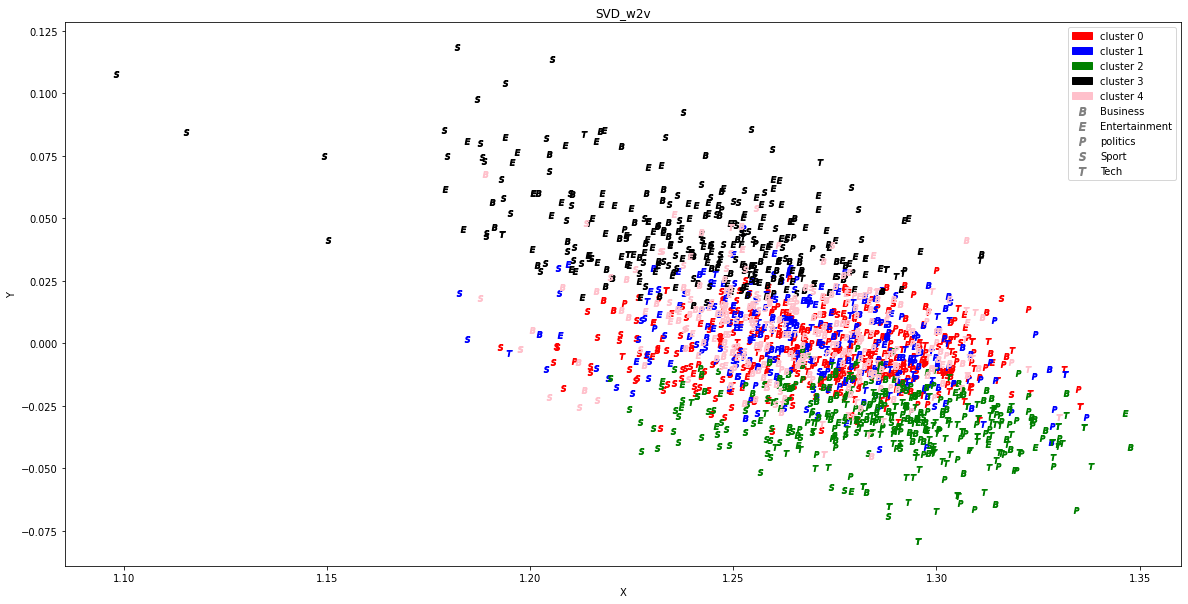

<Figure size 432x288 with 0 Axes>

In [18]:
plt.figure(num=8, figsize=(20, 10))
plot_SVD_data(w2v_vectors, clusters, y_train, 'SVD_w2v')

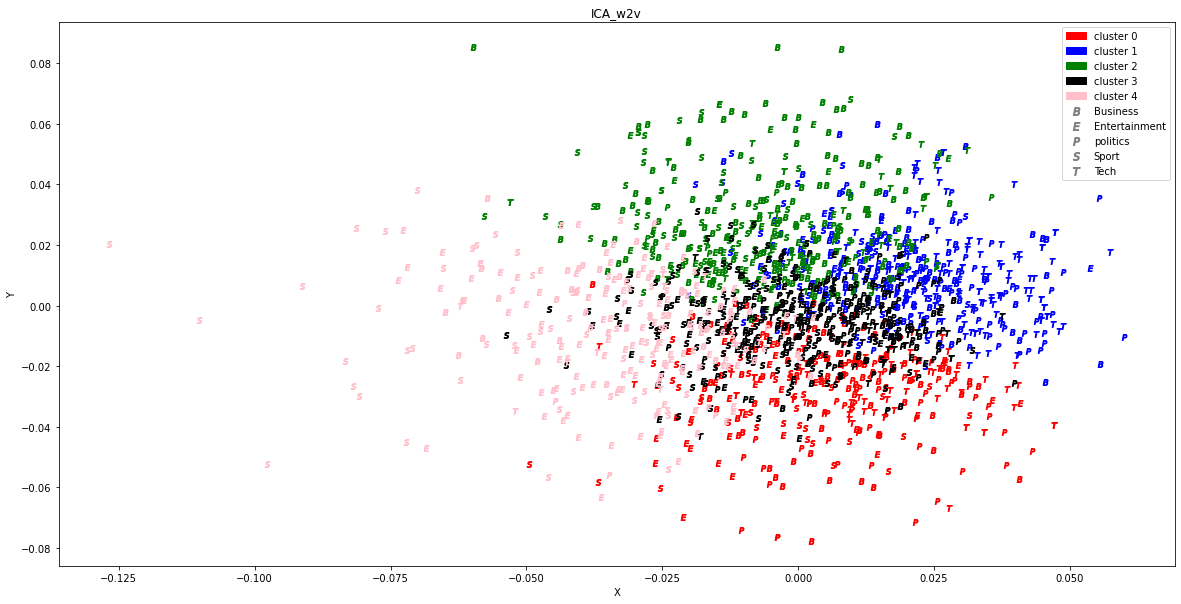

<Figure size 432x288 with 0 Axes>

In [44]:
plt.figure(num=9, figsize=(20, 10))
plot_ICA_data(w2v_vectors, clusters, y_train, 'ICA_w2v')